# Astro 534 "Extragalactic Universe" (Project 1)

# Review the methodology for inferring Hubble constant

# Motivation:
The Hubble constant $H_0$ is a measure of the rate at which the universe is expanding. It is an important to determine the value accurately in cosmology, as it is related to the evolution of the universe. There are several methods used to measure $H_0$, such as using Type Ia supernovae (SNe Ia), cosmic microwave background (CMB) radiation, gravitational lensing, gravitational wave and etc.

However, the value of $H_0$ diverge by using different methods. 

- CMB gives a value of $H_0 = 67.36\pm 0.54 \; \mathrm{km/s/Mpc}$.

- SNe Ia gives a value of $H_0 = 73.24 \pm 1.62\; \mathrm{km/s/Mpc}$.

- Gravitational Wave gives a value of $H_0 = 75^{+40}_{-32}\; \mathrm{km/s/Mpc}$.
<img src="Hubble_constant.png" alt="isolated" width="1280"/>

*(SOARES-SANTOS, PALMESE et al.)*

## But we got only one Universe, so the results must agree with each others. 

The discrepancy arises may because of 

- Data error

- Analysis error

- Model error

So by the guidance of $H_0$, we can review our methodology to find out our mistakes and complete the physics.

In this study, we will review the method used to infer $H_0$ by using Type Ia supernovae.


# Method:

SNe Ia can be used as "standard candles" (they are produced by the explosion of a white dwarf star which releases roughly the same amount of energy) to infer the value of the Hubble constant by Hubble flow:
$$
d_\mathrm{L} = \frac{v}{H_0} = \frac{c}{H_0}z,
$$
where $v$ is the recessional velocity and $d_\mathrm{L}$ is the distance.
We can parametrize the $H_0$ with a dimensionless parameter $h_100$ such that $h_{100} H_{100} =  H_0$ where $ H_{100} =100 \; \mathrm{km/s/Mpc}$.
And the equation becomes 
$$
d_\mathrm{L} = \frac{c}{H_{100}}\frac{z}{h_{100}}.
$$
The main ingredients in this method are the luminosity distance and redshift. Once we got $d_\mathrm{L}$ and $z$, we can infer the $H_0$ by simple curve fitting.



# Data 
SNe Ia have a very specific and predictable brightness which is good for measuring cosmic distances. We can measure the B-band apparaent magnitude of the supernova $m_B$. By comparing it to the peak brightness $M_B$, we can determine $d_\mathrm{L}$.

On the other hand, we can get the redshift $z$ by spectroscopy and then convert it ot CMB frame.



# Calibration  
Calibrating the M_B is necessary in order to use them as standard candles for measuring $d_\mathrm{L}$.
SNe Ia are good candidates for cosmology because they have well-known light curve shape and a consistent luminosity at maximum brightness. 
However, not all of them have exactly the same $M_B$. There are several factors that can affect the observed brightness of a Type Ia supernova, including the shape of its light curve, its color, and any dust that may be present along the line of sight. Therefore, in order to use them as standard candles, we need to calibrate their $M_B$.

There are many ways to calibrate it, here we list some of them:

- Phillips relation: It is an empirical relationship between the luminosity decline rate and peak luminosity of SNe Ia, it contains one free parameter to correct the $M_B$ by a linear relation.

- Cepheid variable stars method: Cepheid variable stars in nearby galaxies have well-know observed periods and colors which can be used to estimate their distances, and then these distances were used to calibrate the luminosities of nearby SNe Ia.

- SALT2 method: It fits a linear regression to the relation between $M_B$ and the light-curve shape parameter, which is a measure of the supernova decline rate.



# Import packages needed 

In [1]:
import numpy as np
import corner.corner as cc
import matplotlib.pyplot as plt
import emcee
import matplotlib.lines as mlines
import matplotlib.ticker as tck
from astropy.cosmology import LambdaCDM
import astropy.units as u
%matplotlib inline
plt.style.use('../../mplstyle.txt')
np.random.seed(0)

# Functions for plotting things

In [12]:
def overlap_corner(s, colors, corner_labels, data_labels, levels=(0.5,0.7,0.9)):    
    fig = cc(s[0],density=True,level=levels,color=colors[0],max_n_ticks=4,
              plot_datapoints=False, plot_density=False, plot_contours=True,labels=corner_labels,
              fill_contours=False,hist_kwargs={'density':True},label_kwargs={'fontsize':15})
    for i in range(1,len(s)):
        fig = cc(s[i],density=True,level=(0.5,0.7,0.9),color=colors[i],max_n_ticks=4,
                  plot_datapoints=False, plot_density=False, plot_contours=True,
                  fill_contours=False,hist_kwargs={'density':True},fig=fig)

    for ax in fig.axes:
        ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
        ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
        ax.tick_params(axis='both', labelsize=15)
    plt.legend(
            handles=[
                mlines.Line2D([], [], color=colors[i], label=data_labels[i])
                for i in range(len(s))
            ],
            fontsize=20, frameon=False,
            bbox_to_anchor=(1, 3), loc="upper right"
        )
    return fig

def plot_result(ax, xlim, paramters, label, color = 'steelblue'):
    x = np.linspace(0.01,xlim,100)
    p = np.random.permutation(paramters.shape[0])
    samples = paramters[p[:300]]
    # expected Hubble law
    y = np.zeros((samples.shape[0],x.size))
    for i in range(samples.shape[0]):
        y[i] = dL_astropy(x, samples[i,0], samples[i,2], samples[i,1] ) 
    percentiles = [50, 5, 16, 84, 95]
    p = {}
    for perc in percentiles:
        p[perc] = np.percentile(y, perc, axis = 0)
    # CR
    ax.fill_between(x, p[95], p[5], color = 'mediumturquoise', alpha = 0.5)
    ax.fill_between(x, p[84], p[16], color = 'darkturquoise', alpha = 0.5)
    ax.plot(x, p[50], lw = 0.7, color = color, label=label)

def plot_samples(ax, x, y, dy, xlim, label, color = 'steelblue'):
    lim = x < xlim
    ax.errorbar(x[lim], y[lim], yerr=dy[lim], c=color, marker='.', markersize=2,
                capsize=1, alpha=0.8, ls='None', lw=0.7, label=label)
  

# Calculation of luminosity distance
The luminosity distance $d_\mathrm{L}$ is defined as
$$
   F = \frac{L}{4\pi d_L^2},
$$
where $F$ is the observed flux and $L$ is the luminosity.
And it's related to the comoving distance by 
$$
    d_\mathrm{L} = r (1+z),
$$
where $z$ is the redshift And the comoving distance to the emitter at redshift $z$.
Notice that we will take the redshift in CMB frame since we can eliminate the motion of our galaxy and the local group of galaxies from the observed redshift of the distant object, and obtain a more accurate measurement of its recession velocity $v$.

In this project, we are going to use the function in `astropy` to compute $d_\mathrm{L}$ based on $\Lambda \mathrm{CMD}$ model. 
It takes several cosmological paramters, but we only consider three of them here:

- $h_{100}$: dimensionless Hubble paramters
- $\Omega_\mathrm{m0}$: matter density at present time
- $\Omega_\mathrm{de0}$: dark energy density at present time

In [3]:
def dL_astropy(z, Omegam, OmegaL, h100 ):
    # H0: Hubble constant
    # Om0: matter density
    # Ode0: dark energy density
    cosmo = LambdaCDM(H0=100*h100, Om0=Omegam, Ode0=OmegaL)
    # luminosity_distance(z) returns (1+z)r in Mpc where r is the comoving distance from 0 to z.
    return cosmo.luminosity_distance(z=z) / u.Mpc / 1000. # In Gpc

cH0 = 2.998  # Hubble radius in Gpc: speed of light divided by 100 km/s/Mpc

## Fitting method:
We will use Markov chain Monte Carlo (MCMC) to fit the data with a straight line by using least-squares fit where the likelihood is defined as
$$
p(D|\Omega_\mathrm{m0},H_0,\Omega_\mathrm{de0}) = \prod^n \frac{1}{2\pi \sigma_n}\exp \left(-\frac{1}{2}\frac{(d_\mathrm{L}-d_\mathrm{L,pred})^2}{\sigma_n^2}\right),
$$
where $\Omega_\mathrm{m0},H_0,\Omega_\mathrm{de0}$ is the luminosity distance predicted by `astropy` and $\sigma_n=\delta d_\mathrm{L}$. 

Then, with Bayes' theorm, we can write:
$$
p(\Omega_\mathrm{m0},H_0,\Omega_\mathrm{de0}|D) \propto \pi(\Omega_\mathrm{m0},H_0,\Omega_\mathrm{de0})p(D|\Omega_\mathrm{m0},H_0,\Omega_\mathrm{de0}),
$$
where $p(\Omega_\mathrm{m0},H_0,\Omega_\mathrm{de0}|D)$ is the posterior of the inferred parameters and $\pi$ is the prior for the parameters.

By using the about formula, we can get the posterior of cosmological parameters that favour the observation data by MCMC.

In [4]:
class MCMC():
    def __init__(self, model, ndim =3, nwalkers=30, bound=np.array([[0.0,1.0],[0.5,1.0],[0,1]])):
        # Define the number of walkers, the number of dimensions in the parameter space
        self.ndim = ndim
        self.nwalkers = nwalkers
        self.bound = bound # prior range
        self.model = model # model used to predict luminosity distance
        self.hypervolume = np.prod(np.diff(bound,axis=1))
    # Define the log prior function
    def log_prior(self, cube):
        indicator = True 
        for i in range(cube.size):
            indicator *= cube[i] > self.bound[i,0]
            indicator *= cube[i] < self.bound[i,1]
        if not indicator:
            return -np.inf
        else:
            return np.log(1./self.hypervolume)
    # Define the log likelihood function
    def log_likelihood(self, params, z, d, derr):
        om, h, ol  = params
        d_pred = self.model(z, om, ol, h )
        # Least square fit for luminosity distance
        sigma2 = derr**2 
        return -0.5 * np.sum((d - d_pred) ** 2 / sigma2 + np.log(sigma2)) # drop 2pi because its constant 
        
    # Define the log posterior function
    def log_posterior(self, params, z, d, derr):
        lp = self.log_prior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood(params, z, d, derr)

    def run(self, z_samples, dl_samples, dlerr_samples, flat=True, discard=200, n_steps=1000, progress=True):
        # Initialize the walkers with uniform random positions
        pos = np.random.uniform(self.bound[:,0], self.bound[:,1],size=(self.nwalkers, self.ndim))
        # Set up the sampler
        sampler = emcee.EnsembleSampler(self.nwalkers, self.ndim, self.log_posterior, args=[z_samples, dl_samples, dlerr_samples])
        # Run the MCMC 
        pos = sampler.run_mcmc(pos, n_steps,progress=progress)
        return sampler.get_chain(flat=flat,discard=discard) # return samplpes after dropping the first few steps

## Let's focus on one dataset first
## Supernova dataset 1, $D_1$:
The first dataset $D_1$ is from newest surveys [Pantheon and SH0ES](https://github.com/PantheonPlusSH0ES/PantheonPlusSH0ES.github.io) with 1701 samples in `Pantheon+SH0ES.dat`.
[This link](http://supernova.lbl.gov/Union/descriptions.html#Magvsz) describes the data columns.
Dowloaded from [here](https://github.com/PantheonPlusSH0ES/DataRelease/tree/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR).

To calculate the distance, we make use of the following formula:
$$
m_B - M_B = 5 \log(d_\mathrm{L}) - 5,\\
d_\mathrm{L} = 10^{0.2( m_B - M_B)+1},\\
d_\mathrm{L} = 10^{ 0.2\mu} \times 10^{-8} \mathrm{Gpc},\\
$$
where $\mu= m_B - M_B$ is the distance modulus. 

Here, we will see how the corrected $M_B$ will change the inferred result.

1701 supernovae in the file.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 38.78it/s]


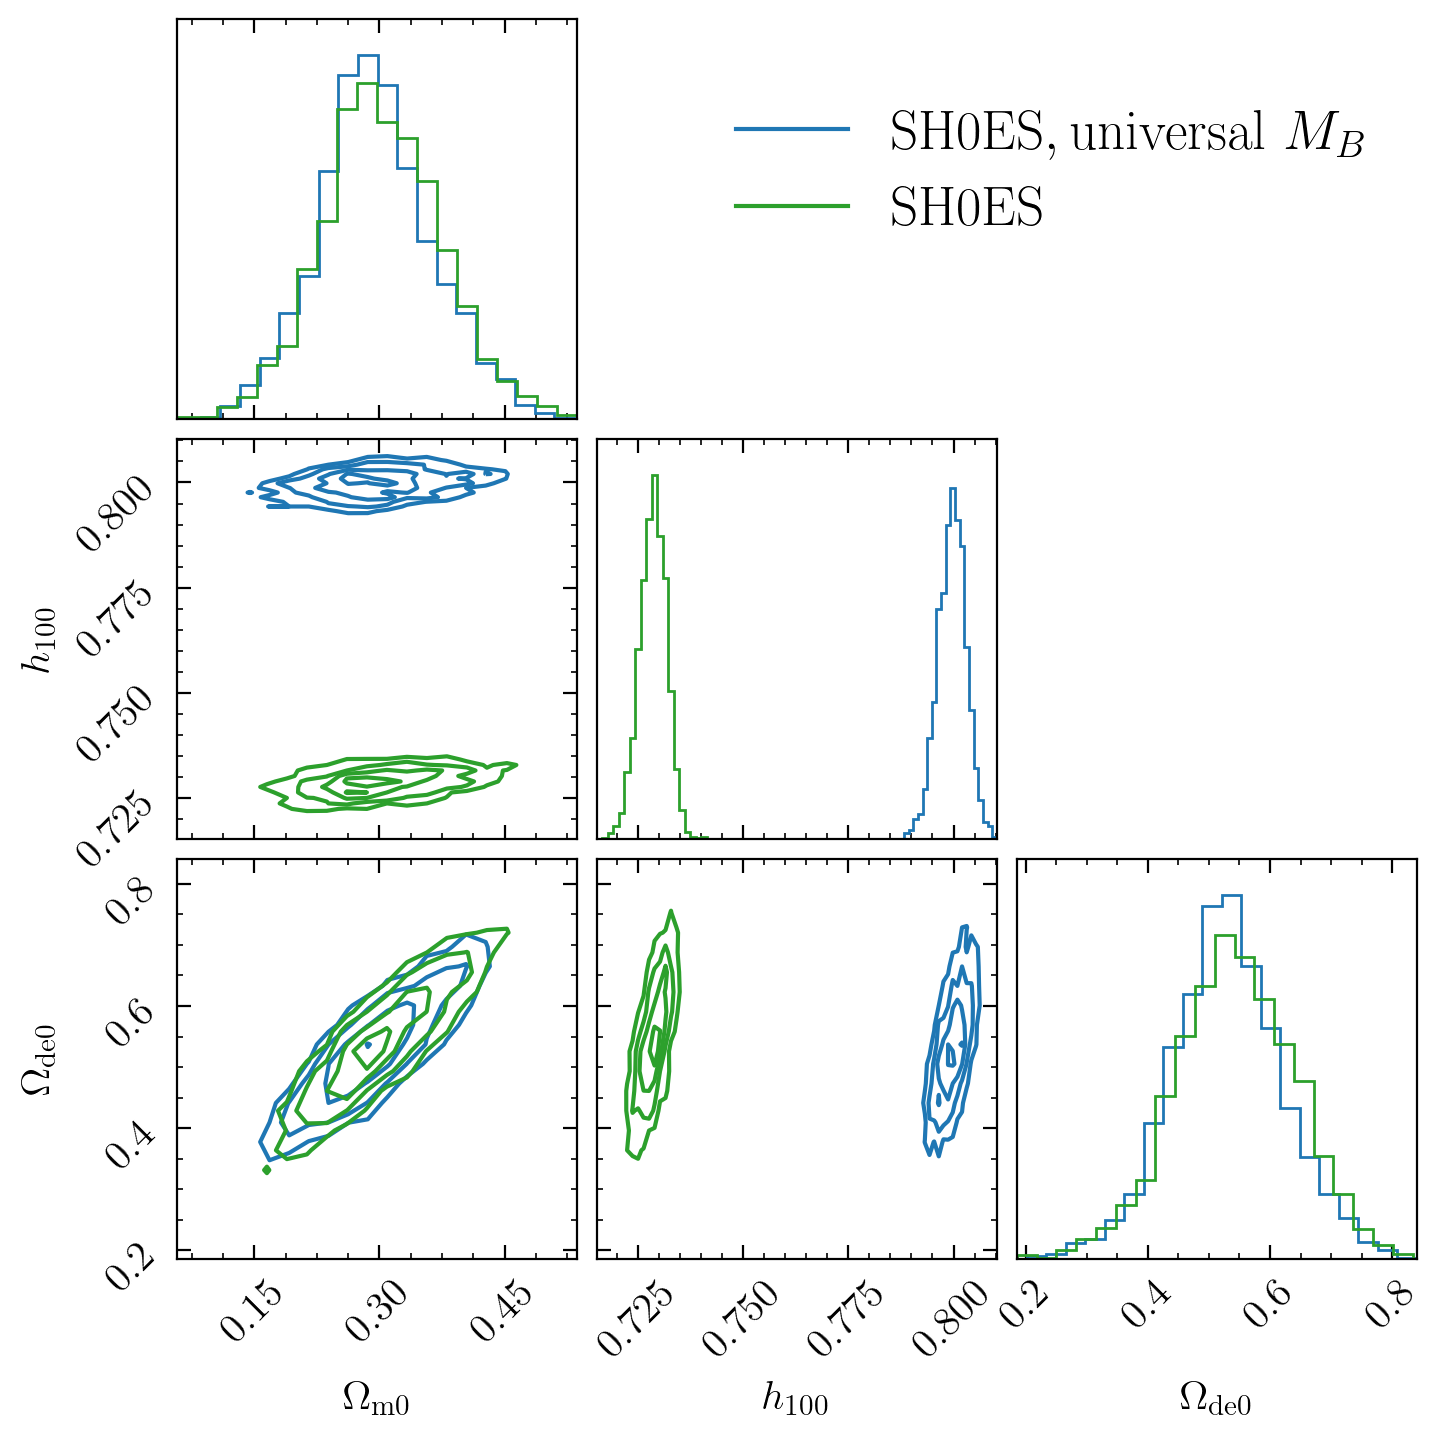

In [18]:
M0sn = -19.05 # assumed universal absolute magnitude
data = np.genfromtxt('data/Pantheon+SH0ES.dat',dtype=str,skip_header=0)
names = data[0]
data = np.genfromtxt('data/Pantheon+SH0ES.dat',skip_header=1)
z1 = data [:,np.where(names=='zCMB')]
mB1 = data[:,np.where(names=='m_b_corr')]
emB1 = data[:,np.where(names=='m_b_corr_err_DIAG')]
del data 
print('%d supernovae in the file.' % np.size(z1))

mu1 = mB1 - M0sn             # distance modulus
dmu1 = emB1
dl1 = 1.e-8*10.**(0.2*mu1) # luminosity distance in Gpc
dl1_err = dl1*np.log(10) *0.2* dmu1 
mcmc = MCMC(model=dL_astropy)
n_steps=500
test_samples = mcmc.run(z1, dl1, dl1_err,n_steps=n_steps)


## Calibrated absolute magnitude
data = np.genfromtxt('data/DataRelease/Pantheon+_Data/4_DISTANCES_AND_COVAR/Pantheon+SH0ES.dat',dtype=str,skip_header=0)
names = data[0]
data = np.genfromtxt('data/DataRelease/Pantheon+_Data/4_DISTANCES_AND_COVAR/Pantheon+SH0ES.dat',skip_header=1)
z1 = data [:,np.where(names=='zCMB')]
mu1 = data[:,np.where(names=='MU_SH0ES')]
dmu1 = data[:,np.where(names=='MU_SH0ES_ERR_DIAG')]
dl1 = 1.e-8*10.**(0.2*mu1) # luminosity distance in Gpc
dl1_err = dl1*np.log(10) *0.2* dmu1 
shoes_samples = mcmc.run(z1, dl1, dl1_err,n_steps=n_steps)

corner_labels = [r'$\Omega_\mathrm{m0}$',r'$h_{100}$',r'$\Omega_\mathrm{de0}$']
test_labels = [r'$\mathrm{SH0ES,universal}\ M_B$',r'$\mathrm{SH0ES}$']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [colors[0], colors[2], colors[3]]
fig = overlap_corner([test_samples,shoes_samples], colors, corner_labels, test_labels)

Blue curves represent the sampled posterior distribution by injecting data when universal $M_B$. Green curves are those by injecting data with $M_B$ calibration.

The contour lines represent 50%, 70% and 90% confidence intervals of the distribution. 

We can see that the $M_B$ correction make a huge difference for the inferred cosmological parameters.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:14<00:00, 40.02it/s]


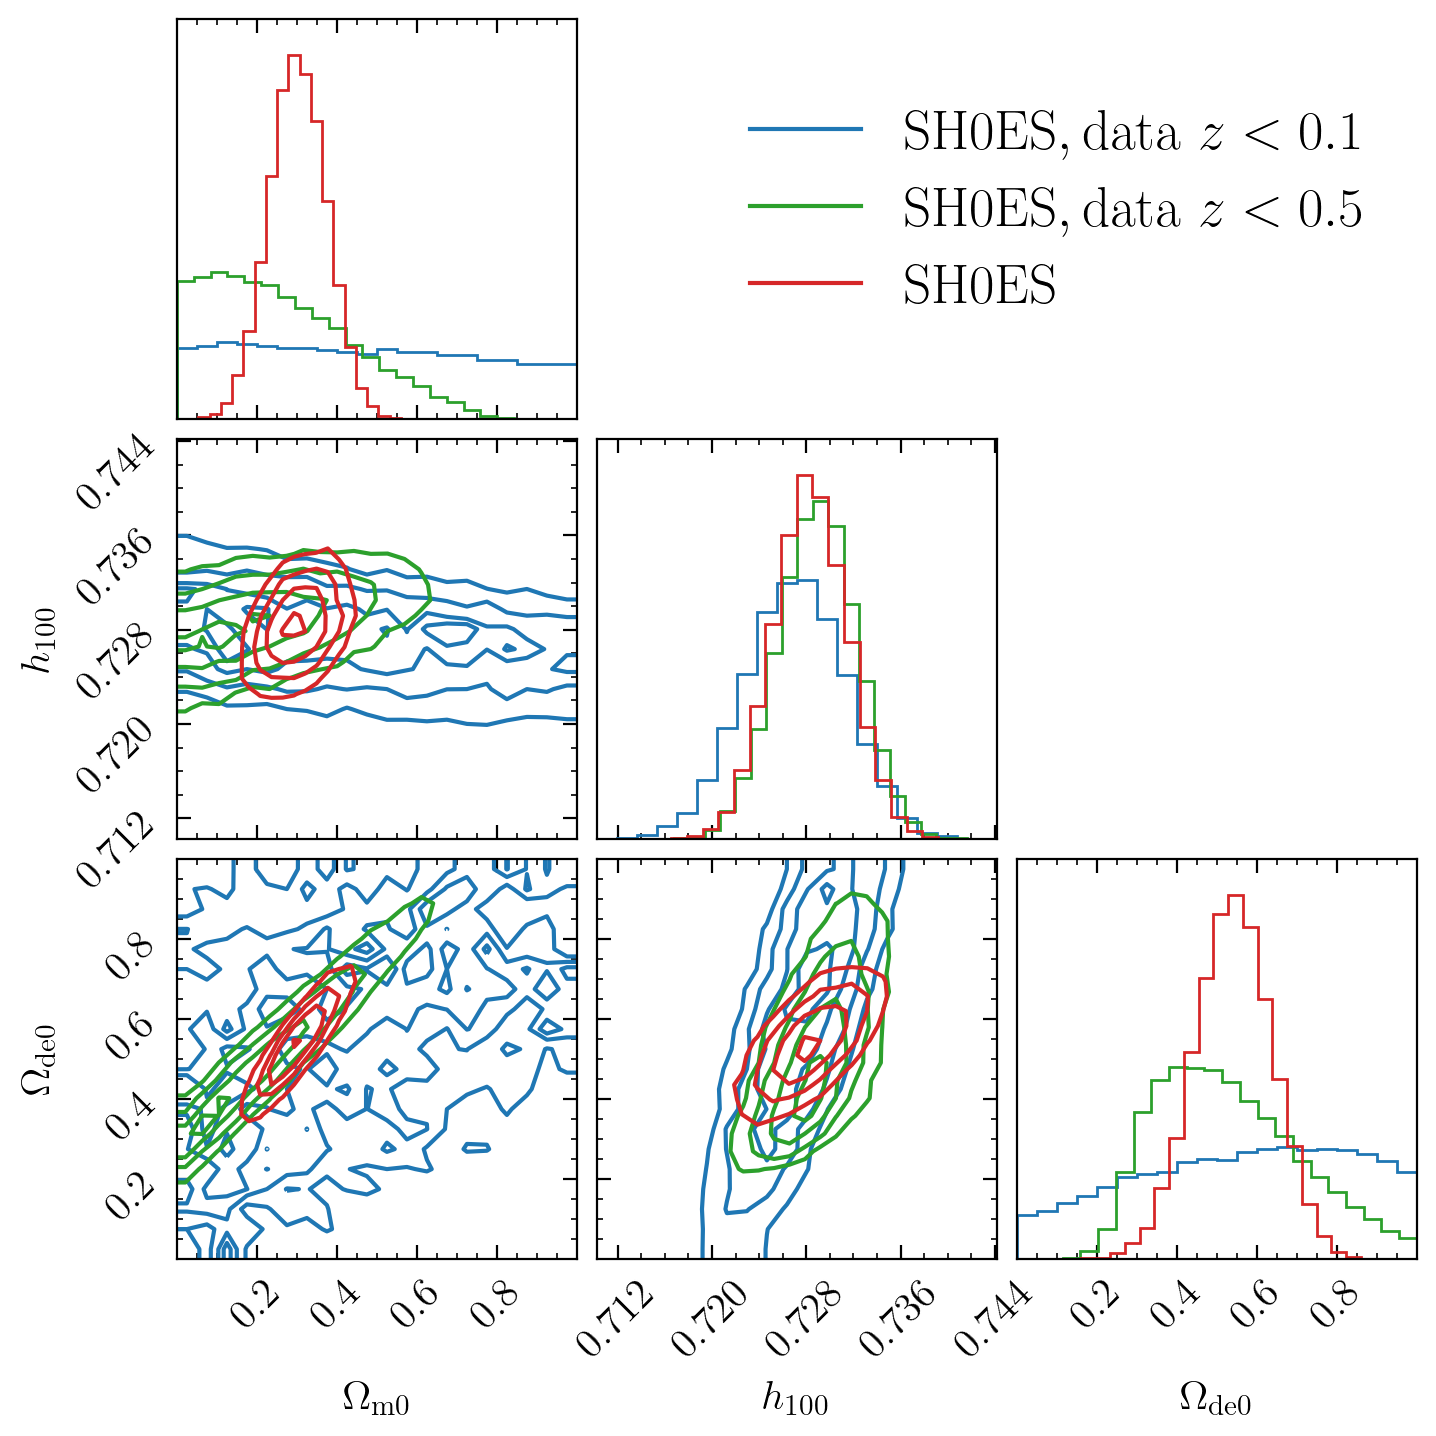

In [6]:
zlim = 0.1
## Calibrated absolute magnitude
data = np.genfromtxt('data/Pantheon+SH0ES.dat',dtype=str,skip_header=0)
names = data[0]
data = np.genfromtxt('data/Pantheon+SH0ES.dat',skip_header=1)
z1 = data [:,np.where(names=='zCMB')]
mu1 = data[:,np.where(names=='MU_SH0ES')]
dmu1 = data[:,np.where(names=='MU_SH0ES_ERR_DIAG')]
dl1 = 1.e-8*10.**(0.2*mu1) # luminosity distance in Gpc
dl1_err = dl1*np.log(10) *0.2* dmu1 
index = np.where(z1<zlim)[0]
test_samples = mcmc.run(z1[index], dl1[index], dl1_err[index],n_steps=n_steps)

zlim = 0.5
index = np.where(z1<zlim)[0]
test2_samples = mcmc.run(z1[index], dl1[index], dl1_err[index],n_steps=n_steps)


shoes_samples = mcmc.run(z1, dl1, dl1_err,n_steps=n_steps)

corner_labels = [r'$\Omega_\mathrm{m0}$',r'$h_{100}$',r'$\Omega_\mathrm{de0}$']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [colors[0], colors[2], colors[3]]
test_labels = [r'$\mathrm{SH0ES,data}\ z<0.1$', r'$\mathrm{SH0ES,data}\ z<0.5$', r'$\mathrm{SH0ES}$']
fig = overlap_corner([test_samples, test2_samples, shoes_samples], colors, corner_labels, test_labels)


The contour lines represent 50%, 70% and 90% confidence intervals of the distribution. 
When only use the data for $z<0.1,0.5$, the posteriors for $\Omega_\mathrm{m0}$ and $\Omega_\mathrm{de0}$ are flatten out, while $h_{100}$ does not. It's because we are fitting the data with Hubble's law, which has a strong dependence on $h_{100}$. While $\Omega_\mathrm{m0}$ and $\Omega_\mathrm{de0}$ only take place when calculating the luminosity distance and they will have larger contribution when $z$ is large. They describe the properties of the whole Universe which require the dataset to cover a bigger volume of the Univese to get a more confident inferred result.

## Next, we compare the inferred results from different dataset.

## Supernova dataset 2, $D_2$:
This is 740 supernovae from the survey of [Betoule et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014A%26A...568A..22B/abstract) in `jla_lcparams.txt`. [This link](http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html) describes the data columns. 
From this file we will read the SN redshift, apparent B magnitude, and its measurement error.

Notice that this dataset we don't have the correted $M_B$ so we need to assume a universal $M_B$ thus the inferred result may not be accurate.

In [7]:
# z2, ez2: SNIa redshifts and its error in the CMB frame
# mB2, emB2: apparent B-magnitude and its error
z2, ez2, mB2, emB2 = np.loadtxt('data/jla_lcparams.txt', usecols=(1,3,4,5), unpack=True)

print('%d supernovae in the file.' % np.size(z2))
M0sn = -19.05 # assumed universal absolute magnitude
mu2 = mB2 - M0sn             # distance modulus
dmu2 = emB2
dl2 = 1.e-8*10.**(0.2*mu2) # luminosity distance in Gpc
dl2_err = dl2 * np.log(10)*0.2*dmu2 # error for luminosity distance 

#mcmc = MCMC(model=dL_astropy)
d2_samples = mcmc.run(z2, dl2, dl2_err,n_steps=n_steps)

740 supernovae in the file.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:46<00:00, 64.49it/s]


## Supernova dataset 3, $D_3$:
The second dataset $D_2$ is from the Supernova Cosmology Project [Union dataset](http://supernova.lbl.gov/Union/) with 580 samples in `SCPUnion2.1_mu_vs_z.txt`.
[This link](http://supernova.lbl.gov/Union/descriptions.html#Magvsz) describes the data columns.

Notice that this dataset already calibrated the $M_B$ and we directly getting $\mu$ from the dataset.

In [8]:
# z3, ez3: SNIa redshifts and its error in the CMB frame
# mu3, emu3: Distance Modulus and its error
z3, mu3, emu3 = np.loadtxt('data/SCPUnion2.1_mu_vs_z.txt', usecols=(1,2,3), unpack=True)
# calculation for dL
dl3 = 1.e-8*10.**(0.2*mu3)  # luminosity distance in Gpc
dmu3 = emu3
dl3_err = dl3*np.log(10) * 0.2* dmu3
print('%d supernovae in the file.' % np.size(z3))
d3_samples = mcmc.run(z3, dl3, dl3_err,n_steps=n_steps)

580 supernovae in the file.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:47<00:00, 63.04it/s]


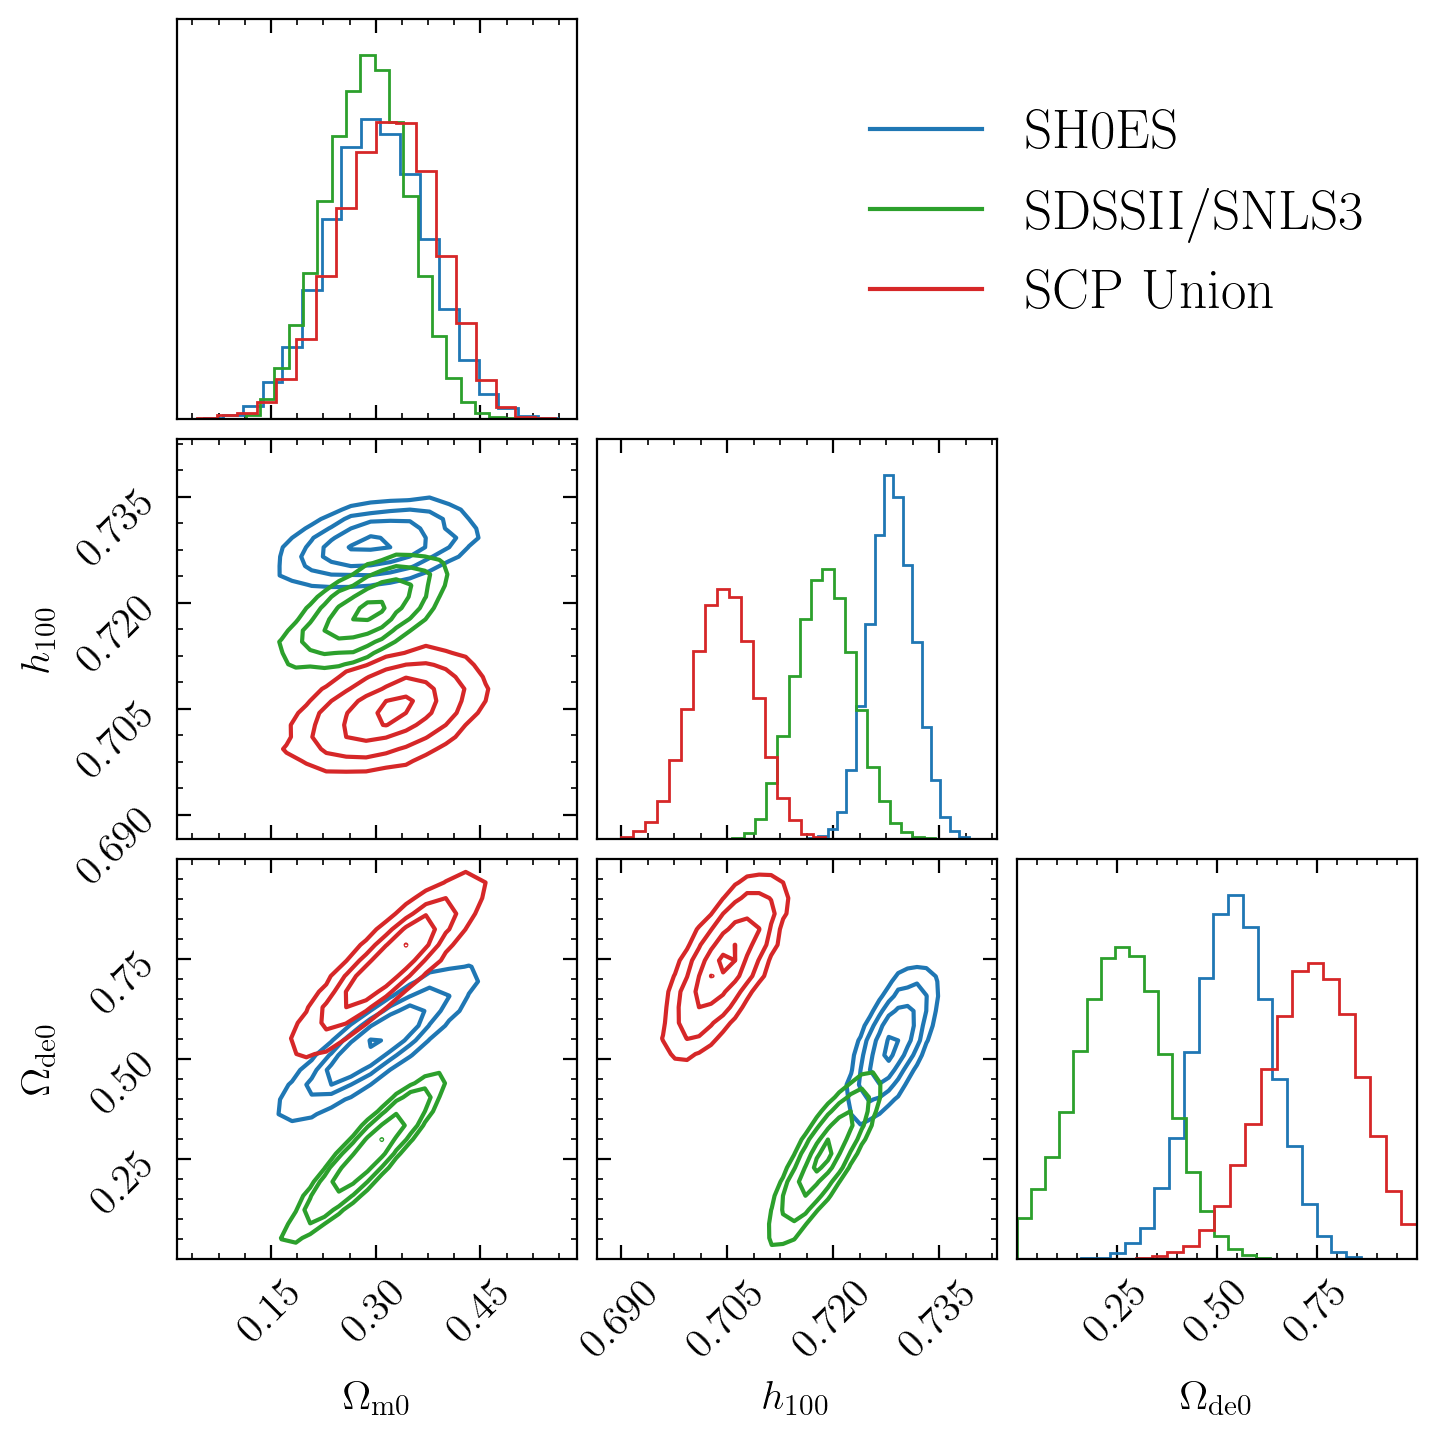

In [13]:
# Poltting results for different dataset
data_labels = [r'$\mathrm{SH0ES}$',r'$\mathrm{SDSSII/SNLS3}$',r'$\mathrm{SCP\ Union}$']
fig = overlap_corner([shoes_samples, d2_samples, d3_samples,], colors, corner_labels, data_labels)

The contour lines represent 50%, 70% and 90% confidence intervals of the distribution. 

Here we can see the inferred $h_{100}$ and $\Omega_\mathrm{de0}$ have big discrepancy with different datasets.

And convert $h_{100}$ to $H_0$ with error bar being $16\%,84\%$ percentiles , we have 

In [14]:
from IPython.display import display, Latex
s = [shoes_samples, d2_samples, d3_samples]
[r'$\mathrm{SH0ES}$',r'$\mathrm{SDSSII/SNLS3}$',r'$\mathrm{SCP\ Union}$']
for i, data in enumerate(data_labels):
    p50 = np.percentile(100*s[i][:,1], 50)
    p16 = np.percentile(100*s[i][:,1], 16)
    p84 = np.percentile(100*s[i][:,1], 84)
    display(Latex(data+r'$:H_0={{{:.2f}}}^{{{:.2f}}}_{{{:.2f}}}\; $'.format(p50,p84-p50,p50-p16)+r'$\mathrm{km/s/Mpc}$'))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

which the inferred result from `SH0ES` dataset has the smallest errorbars and is cloest to the result from [(Riess, 2018)](https://iopscience.iop.org/article/10.3847/1538-4357/aac82e/pdf), $H_0 = 73.24 \pm 1.62\; \mathrm{km/s/Mpc}$.

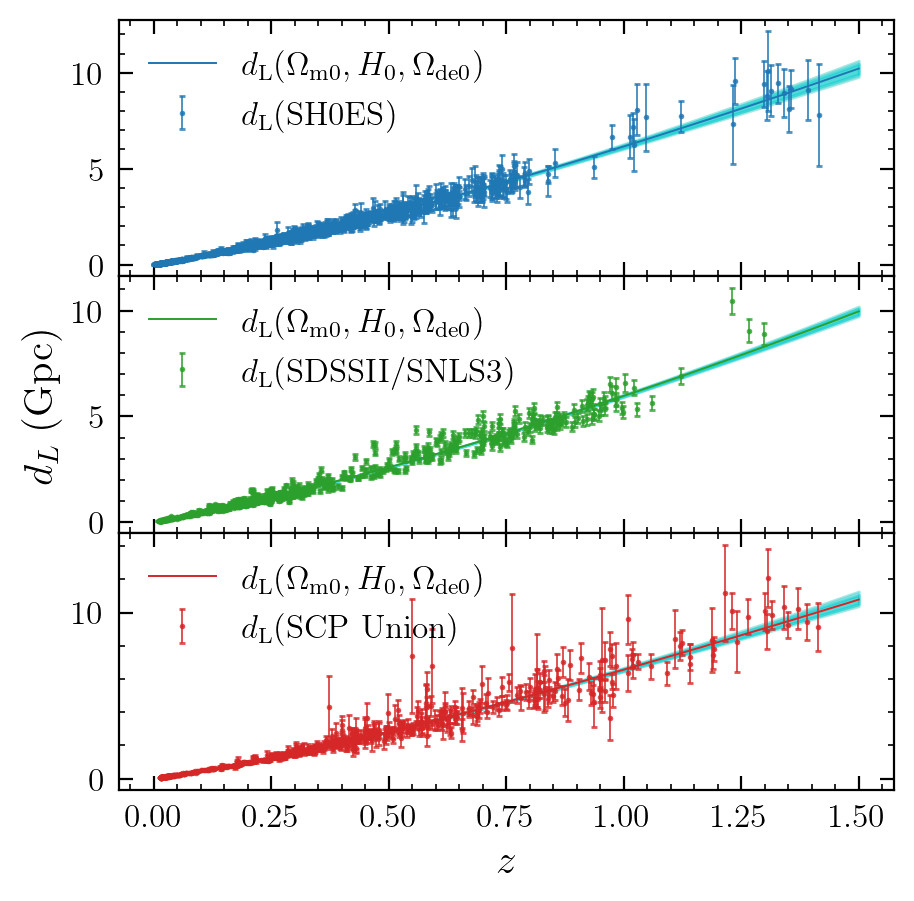

In [15]:
fig, axes = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(5,5))

for i, (z, dl, dl_err, samples) in enumerate(zip( (z1,z2,z3), (dl1, dl2, dl3), (dl1_err, dl2_err, dl3_err), (shoes_samples, d2_samples, d3_samples))):
    ax = axes[i]
    plot_result(ax, 1.5, samples, color = colors[i],
                label = r'$d_\mathrm{L}(\Omega_\mathrm{m0},H_0,\Omega_\mathrm{de0})$')
    plot_samples(ax, z, dl, dl_err, 1.5, label=r'$d_\mathrm{L}($'+data_labels[i]+r'$)$', color = colors[i])
    if i==1: ax.set_ylabel(r'$d_L \; ({\rm Gpc})$')
    if i==2: ax.set_xlabel(r'$z$')

fig.subplots_adjust(wspace=0, hspace=0)
for ax in axes:
    ax.legend()
    ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())

Here we plot the Hubble's law using the inferred parameter to compare with the observation data.

$d_\mathrm{L}(\Omega_\mathrm{m0},H_0,\Omega_\mathrm{de0})$ shaded curve represents the Hubble's law with the inferred parameters.

$d_\mathrm{L}(D)$ represent the observation data.

They agree with each others. This tells us the most important thing in this analysis is the calibration/accuracy of the observed data. The fitting method we are using is straight forward, but the systematic errors from the data itself will introduce a strong bias for the inferred data.


# Conclusion:
We have exmain the inferred results of cosomological parameters using Hubble's law by injecting different datasets. Using latest dataset, the error of inferred $H_0$ is the smallest and the closet to the result from (Riess, 2018).


There are many challenges to using Type Ia supernovae to infer the Hubble constant, including accounting for the effects of dust and other sources of systematic error. We need to use different calibration method to correct the magnitude and even that, we will still get a very large measurement error from high redshift supernovae. 

But it's important to keep doing it until we find a agreement of the inferred $H_0$ from CMB data and SNe Ia data to make sure our physics model is correct.
